# Sky View Factor Processing with Python

This notebook processes the fisheye photographs to create sky view factor values for each station. It uses the the cv2 image library to convert the image to binary values of black (building/tree/other obstruction) and white (sky). The Sky View Factor is defined as the proportion of sky in the image obtained by counting all of the 'sky' pixels and dividing by the total 'sky' and 'building' pixels. For more on the geometry behind this, see , thus ranging from 0 - 1,

In [1]:
## Start by importing our data and the necessary libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

imgs = ['pictures/svf_1.png','pictures/svf_2.png','pictures/svf_3.png']

## What is a fisheye photograph?

A fisheye lens maps a 3D object (a sphere) onto a 2D object (a circle) by mapping each point in the scene to a corresponding angle from the center of the lens. By graphing polar coordinates like below we can see the concentric circles that represent the lines of constant zenith angle in the field of view of the lens, between 0 and 90 degrees. By plotting coordinates on top of the image we can have an idea of how this works

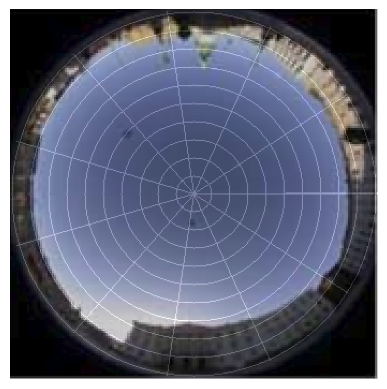

In [2]:
# load the image
img = cv2.imread(imgs[0])

# define the center and the radius of the image (i just assume half and half)
h, w = img.shape[:2]
center = (w//2, h//2)
radius = min(center)

# create a blank image to draw the grid
grid = np.zeros_like(img)

# draw concentric circles
for r in range(0, radius, radius//10):  # adjust the step to change the density of the grid
    cv2.circle(grid, center, r, (255, 255, 255), 1)

# draw radial lines
for theta in np.linspace(0, 2*np.pi, 12):  # adjust the number of lines as needed
    x = int(center[0] + radius * np.cos(theta))
    y = int(center[1] + radius * np.sin(theta))
    cv2.line(grid, center, (x, y), (255, 255, 255), 1)

# add the grid to the image
overlay = cv2.addWeighted(img, 0.8, grid, 0.2, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Simple Threshold Values

To start, we can convert to grayscale and manually set a threshold value for the whole image. This simple method can work for many situations, especially in a mainly open-sky situation. Since the pixel values go from 0-255 run the block to start with a cutoff right in the middle and set ```thresh = 127```. 

Then, try moving the threshold using the  ```thresh``` variable in the below code to try to correct for some of the miscoded values.

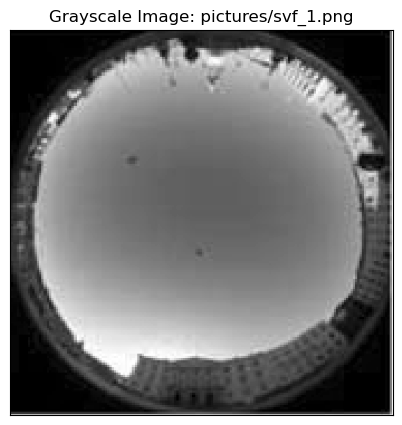

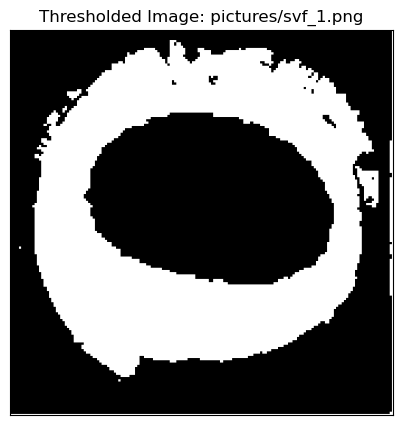

Sky View Factor pictures/svf_1.png: 0.3852368276503148


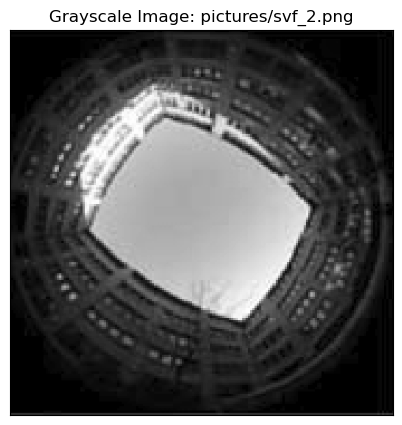

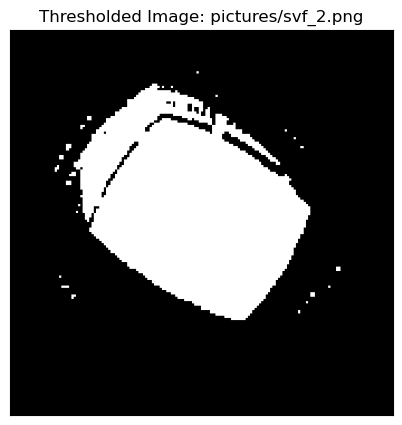

Sky View Factor pictures/svf_2.png: 0.23477415811044916


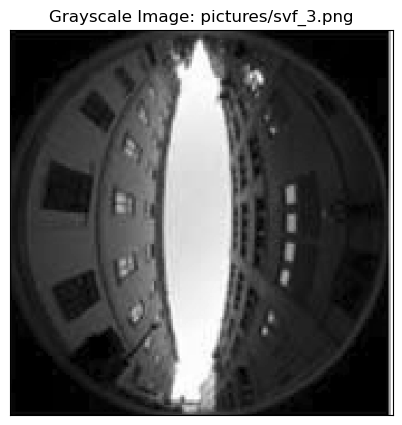

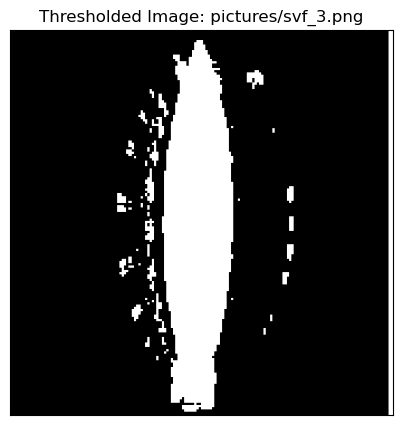

Sky View Factor pictures/svf_3.png: 0.16033295305699918


{'pictures/svf_1.': 0.39, 'pictures/svf_2.': 0.23, 'pictures/svf_3.': 0.16}

In [3]:
# define threshold variable
thresh = 127

# loop through list of images and store ina  dictionary
mydict = {}

for img in imgs:
    # convert to a numeric representation of the grayscale image
    img_numeric  = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    # plot grayscale image for reference
    plt.figure(figsize=(5, 5))
    plt.imshow(img_numeric, cmap='gray')
    plt.title(f'Grayscale Image: {img}')
    plt.xticks([]) 
    plt.yticks([])
    plt.show()

    # Threshold image to segment sky
    _, thresholded_img = cv2.threshold(img_numeric, thresh, 255, cv2.THRESH_BINARY)
    
    # plot thresholded image
    plt.figure(figsize=(5, 5))
    plt.imshow(thresholded_img, cmap='gray')
    plt.title(f'Thresholded Image: {img}')
    plt.xticks([]) 
    plt.yticks([])
    plt.show()

    # Calculate SVF
    svf = np.count_nonzero(thresholded_img) / (thresholded_img.shape[0] * thresholded_img.shape[1])
    mydict[img[:-3]] = svf

    print(f'Sky View Factor {img}:', svf)
{k: np.round(v,2) for k,v in mydict.items()}

## Otsu's Thresholding
Since the straightforward method does not work effectively for these photos, we can use a more complex filtering method. These photos of street canyons are strongly bimodal, that is they have 'building' and 'sky'. Given this fact, we can use [Otsu's threshold](https://learnopencv.com/otsu-thresholding-with-opencv/) method which assumes a bimodal image distribution to better identify the foreground (buildings) and background (sky). This method returns the optimal threshold value to minimize the variance between the two groups in the distribution. This threshold value is then passed to the same ```cv2.THRESH_BINARY``` function that we used before when we manually set the threshold value. Another benefit of this implementatio is that it optimizes the threshold per picture.

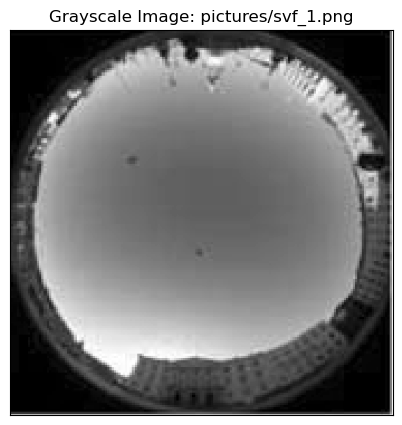

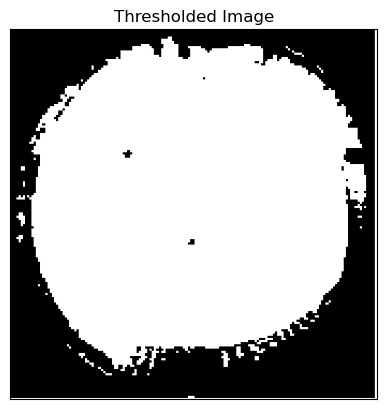

Sky View Factor for pictures/svf_1.png with threshold 89.0, : 0.64


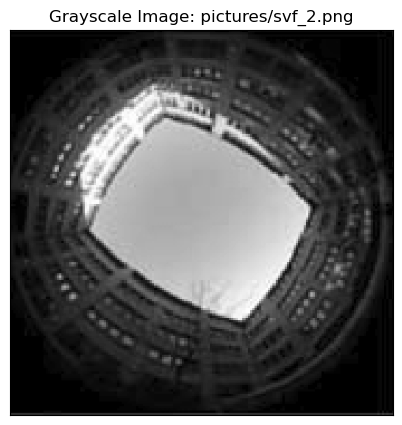

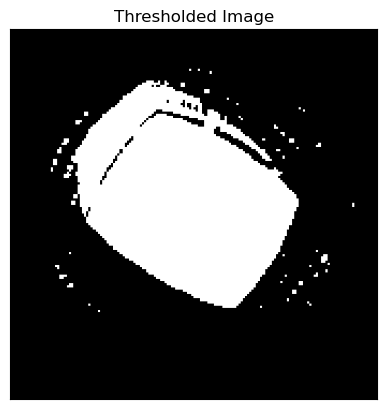

Sky View Factor for pictures/svf_2.png with threshold 111.0, : 0.24


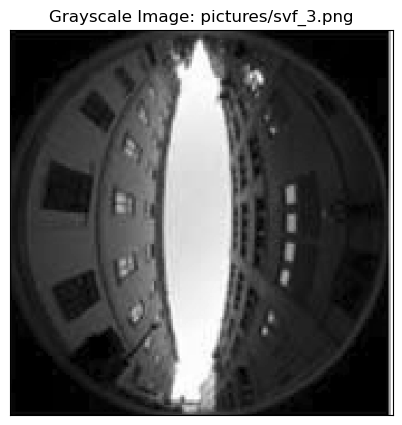

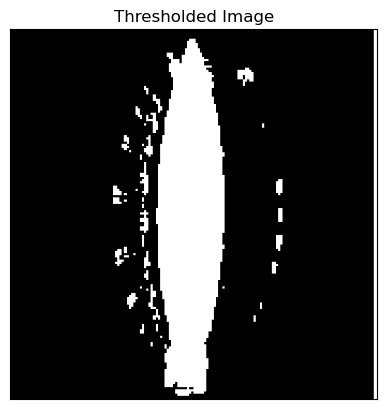

Sky View Factor for pictures/svf_3.png with threshold 128.0, : 0.16


{'pictures/svf_1': 0.64, 'pictures/svf_2': 0.24, 'pictures/svf_3': 0.16}

In [4]:
# loop through the desired images and store in a dictionary
mydict = {}
for img in imgs:
    img_numeric  = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    # Apply Otsu's thresholding
    thresh, thresholded_img = cv2.threshold(img_numeric, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # plot grayscale image for reference
    plt.figure(figsize=(5, 5))
    plt.imshow(img_numeric, cmap='gray')
    plt.title(f'Grayscale Image: {img}')
    plt.xticks([]) 
    plt.yticks([])
    plt.show()
    
    # Display thresholded image
    plt.imshow(thresholded_img, cmap='gray')
    plt.title(f'Thresholded Image'), plt.xticks([]), plt.yticks([])
    plt.xticks([]) 
    plt.yticks([])
    plt.show()
    
    # Calculate SVF
    svf = np.count_nonzero(thresholded_img) / (thresholded_img.shape[0] * thresholded_img.shape[1])
    mydict[img[:-4]]=svf
    print(f'Sky View Factor for {img} with threshold {thresh}, :', np.round(svf,2))
{k: np.round(v,2) for k,v in mydict.items()}

This method works much better, but is also not perfect. We can see the big circle in the middle of photo 1 is gone, but the illuminated building in photo 2 is still passing as sky. Further there are many bright spots that are misclassified as sky on the buildings. This last issue can be solved using denoising.

## Denoising

The isolated bright and dark spots can be removed through a process called denoising. There are number of methods more or less agresive for getting rid of different types of noise in the data. The two demonstrated here in combination with Otsu's thresholding are the ```GassianBlur()``` and ```MedianBlur()``` methods.

The blur intensity can be determined by the parameters ```blur_values```and ```median_control``` at the top of each of the next code blocks. Higher values will blur more. 

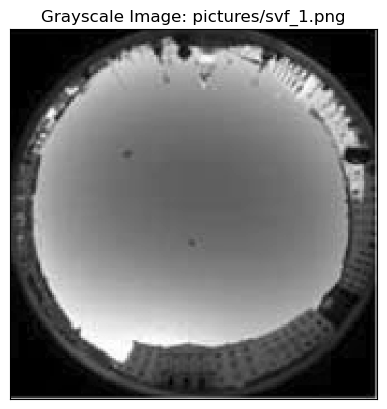

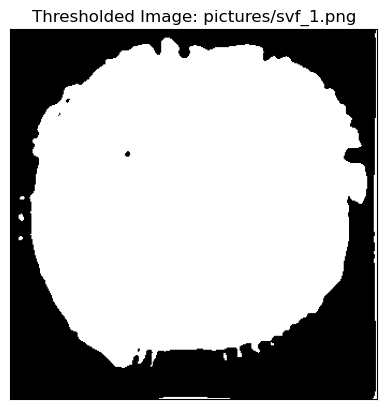

Sky View Factor: pictures/svf_1.png 0.64


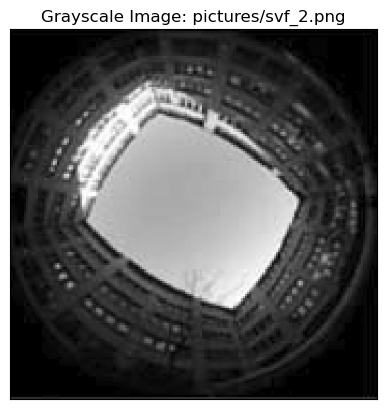

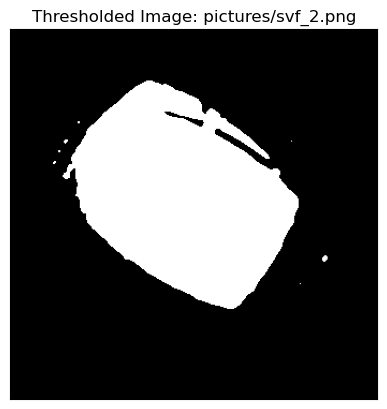

Sky View Factor: pictures/svf_2.png 0.24


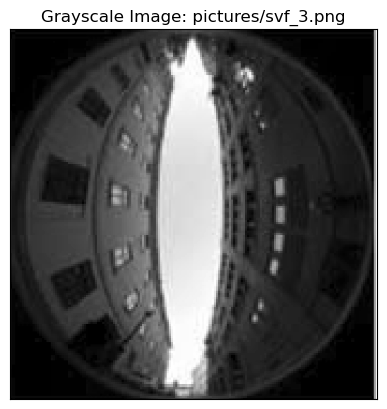

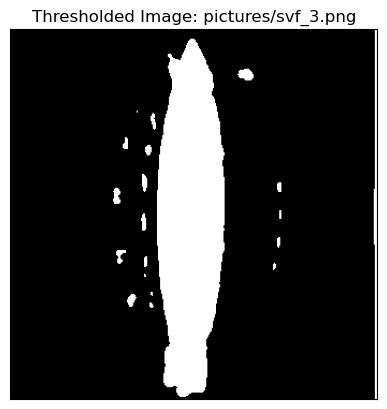

Sky View Factor: pictures/svf_3.png 0.15


{'pictures/svf_1': 0.64, 'pictures/svf_2': 0.24, 'pictures/svf_3': 0.15}

In [5]:
## Gaussian blur
blur_values = (11,11)

# loop through the desired images and store in a dictionary of file name
mydict = {}
for img in imgs:
    # convert to numeric grayscale
    img_numeric  = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    # denoise the image with a Gaussian blur
    denoised_img = cv2.GaussianBlur(img_numeric, blur_values, 0)

    # Apply Otsu's thresholding
    _, thresholded_img = cv2.threshold(denoised_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # plot grayscale image for reference
    plt.imshow(img_numeric, cmap='gray')
    plt.title(f'Grayscale Image: {img}')
    plt.xticks([]) 
    plt.yticks([])
    plt.show()
    
    # Display thresholded image
    plt.imshow(thresholded_img, cmap='gray')
    plt.title(f'Thresholded Image: {img}'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    # Calculate SVF
    svf = np.count_nonzero(thresholded_img) / (thresholded_img.shape[0] * thresholded_img.shape[1])
    mydict[img[:-4]]=svf
    print(f'Sky View Factor: {img}', np.round(svf,2))
{k: np.round(v,2) for k,v in mydict.items()}

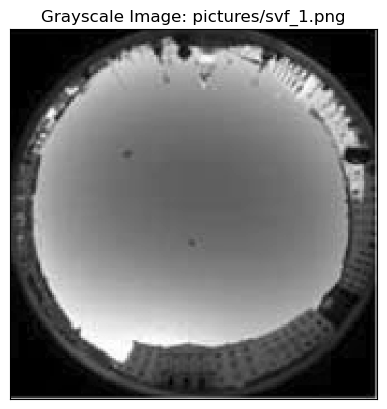

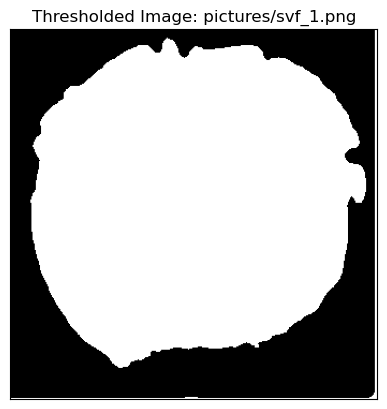

Sky View Factor: pictures/svf_1.png 0.63


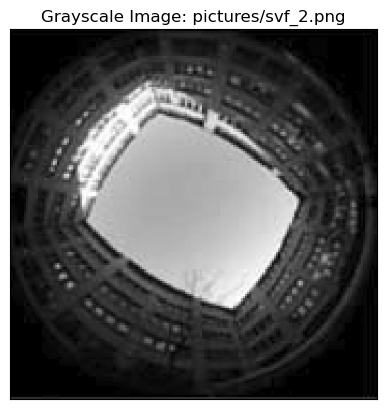

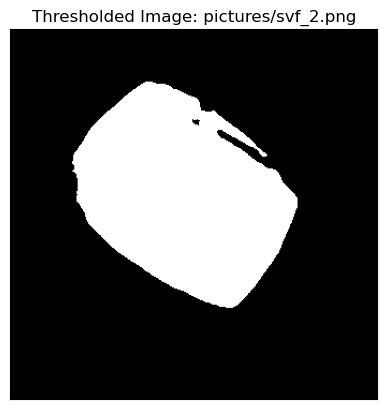

Sky View Factor: pictures/svf_2.png 0.24


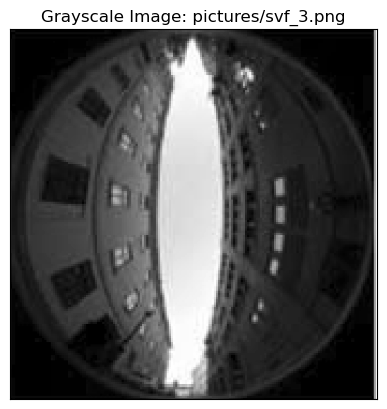

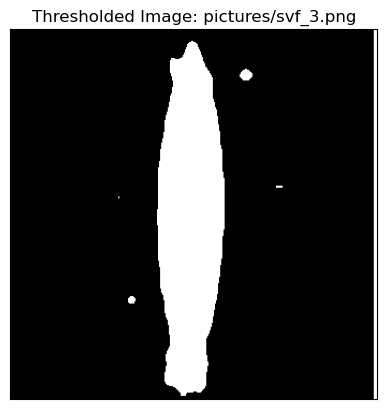

Sky View Factor: pictures/svf_3.png 0.14


{'pictures/svf_1': 0.63, 'pictures/svf_2': 0.24, 'pictures/svf_3': 0.14}

In [6]:
## Median Blur
median_control = 11
mydict = {}
# loop through the desired images
for img in imgs:
    img_numeric  = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    
    # denoise the image
    denoised_img = cv2.medianBlur(img_numeric, median_control)

    # Apply Otsu's thresholding
    _, thresholded_img = cv2.threshold(denoised_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # plot grayscale image for reference
    plt.imshow(img_numeric, cmap='gray')
    plt.title(f'Grayscale Image: {img}')
    plt.xticks([]) 
    plt.yticks([])
    plt.show()
    
    # Display thresholded image
    plt.imshow(thresholded_img, cmap='gray')
    plt.title(f'Thresholded Image: {img}'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    # Calculate SVF
    svf = np.count_nonzero(thresholded_img) / (thresholded_img.shape[0] * thresholded_img.shape[1])
    mydict[img[:-4]]=svf
    print(f'Sky View Factor: {img}', np.round(svf,2))

    # print the dictionary
{k: np.round(v,2) for k,v in mydict.items()}

These final values are close, especially for image 1 and image 3, but image 2 might take manual processing to fill in the very illuminated part of the building that shows up sky.

In [7]:
# now make dictionary of values (I invent some here for the pilot data) to add to the dataset

sensors = [f'20{str(x)}' for x in np.arange(1,8)]
intdict = {f'20{k[-1]}': v for k,v in mydict.items()}
svf_dict = {}
for sensor in sensors:
    if sensor in intdict.keys():
        svf_dict[sensor] = intdict[sensor]
    else:
        svf_dict[sensor] = np.random.uniform(0.5,1)
{k:np.round(v,2) for k,v in svf_dict.items()}

{'201': 0.63,
 '202': 0.24,
 '203': 0.14,
 '204': 0.85,
 '205': 0.98,
 '206': 0.69,
 '207': 0.55}

Finally, save the files.

In [8]:
# now save the files

with open('output.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['sensor', 'svf'])
    for key, value in svf_dict.items():
        writer.writerow([key, value])

## Conclusion

In conclusion, we have looked at fisheye photographs from the sensor locations and used these photographs to create sky view factors for each sensor.

In the next step, the data saved will be attached to the sensor dataset along with other data and metadata and then used to calculate radiation exposure for that sensor.